In [1]:
%load_ext autoreload
%autoreload 2

import ctree

from statsmodels.formula.api import ols
import numpy as np
import matplotlib.pyplot as plt
import pretty

In [2]:
homog = ctree.Dataset(n = 10_000, m = 6, p_treated=0.5)
hetero = ctree.Dataset(n = 10_000, m = 6, p_treated=0.5, homogeneous=False)

# Homogeneous effects and simple heterogeneous effects with no selection

First a simple plot of the data, one $x$ and one $y$

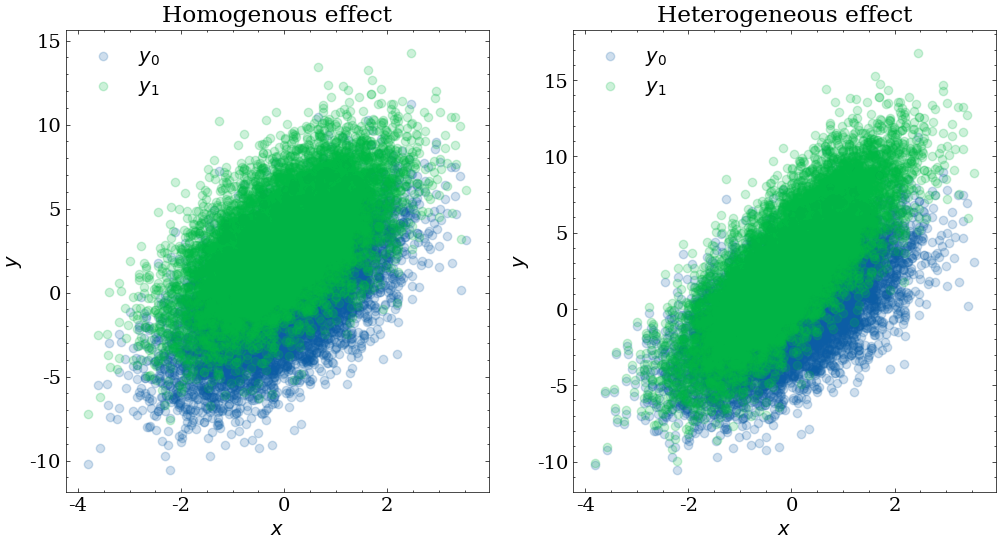

In [3]:
_alph = 0.2

with pretty.Classic():
    fig, ax = plt.subplots(1,2, sharex = True)
    
    hg = homog.df
    het = hetero.df
    
    ax[0].scatter(hg.X0, hg.y0, alpha = _alph, label = '$y_0$')
    ax[0].scatter(hg.X0, hg.y1, alpha = _alph, label = '$y_1$')    
    ax[0].set_title('Homogenous effect')
    
    ax[1].scatter(het.X0, het.y0, alpha = _alph, label = '$y_0$')
    ax[1].scatter(het.X0, het.y1, alpha = _alph, label = '$y_1$')    
    ax[1].set_title('Heterogeneous effect')    
    
    ax[0].set_xlabel('$x$')
    ax[1].set_xlabel('$x$')
    ax[0].set_ylabel('$y$')
    ax[1].set_ylabel('$y$')
    
    ax[0].legend()
    ax[1].legend()    
    
    plt.show()
    

The treatment effect across both treated and untreated for both samples.

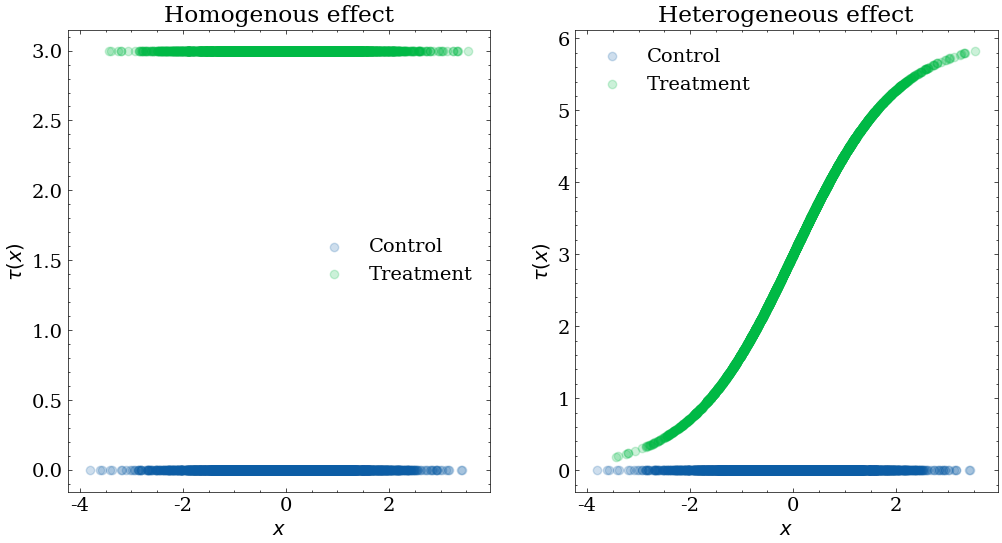

In [4]:
_alph = 0.2

with pretty.Classic():
    fig, ax = plt.subplots(1,2, sharex = True)
    
    hg = homog.df
    het = hetero.df
    
    ax[0].scatter(hg[~hg.t].X0, hg[~hg.t].y - hg[~hg.t].y0, alpha = _alph, label = 'Control')
    ax[0].scatter(hg[hg.t].X0, hg[hg.t].y - hg[hg.t].y0, alpha = _alph, label = 'Treatment')    
    ax[0].set_title('Homogenous effect')
    
    ax[1].scatter(het[~het.t].X0, het[~het.t].y - het[~het.t].y0, alpha = _alph, label = 'Control')
    ax[1].scatter(het[het.t].X0,  het[het.t].y - het[het.t].y0, alpha = _alph, label = 'Treatment')    
    ax[1].set_title('Heterogeneous effect')    

    ax[0].set_xlabel(r'$x$')
    ax[1].set_xlabel(r'$x$')
    ax[0].set_ylabel(r'$\tau(x)$')
    ax[1].set_ylabel(r'$\tau(x)$')
    
    ax[0].legend()
    ax[1].legend()    
    
    plt.show()
    

## Linear model for estimation of causal effect.

In [5]:
model = ols(formula = 'y ~ t', data = homog.df)
res = model.fit()
print('OLS, homogenous case', res.params[1])

model = ols(formula = 'y ~ t', data = hetero.df)
res = model.fit()
print('OLS, heterogeneous case', res.params[1])


OLS, homogenous case 3.0647221689792827
OLS, heterogeneous case 3.0806285750305067


## Transformed outcome trees

In [6]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV


In [7]:
params = {'min_samples_leaf': range(1,20, 2),
          'min_impurity_decrease': np.linspace(0.0,0.1, 10)}

In [8]:
X = hetero.df.drop('y', axis = 1)
y = hetero.df['y']


Xs, ys, Ts, trues = ctree.RCT_train_test_split(X,y)

X_train, X_test = Xs
y_train, y_test = ys
T_train, T_test = Ts
true_train, true_test = trues


In [9]:
tot = ctree.TOTree(**params)
tot.fit(X_train, y_train, T_train)
preds = tot.predict(X_test)

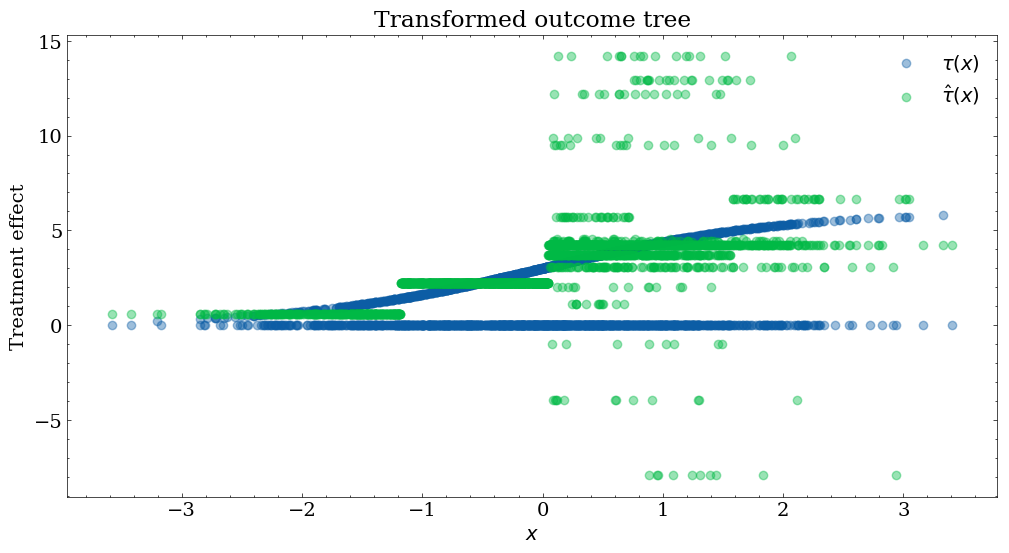

In [10]:
with pretty.Classic():
    fig, ax = plt.subplots()
    
    ax.scatter(X_test['X0'], T_test * true_test , label = r'$\tau(x)$', alpha = 0.4)
    ax.scatter(X_test['X0'], preds, label = r'$\hat{\tau}(x)$', alpha = 0.4)
    
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'Treatment effect')
    ax.set_title('Transformed outcome tree')
    ax.legend()

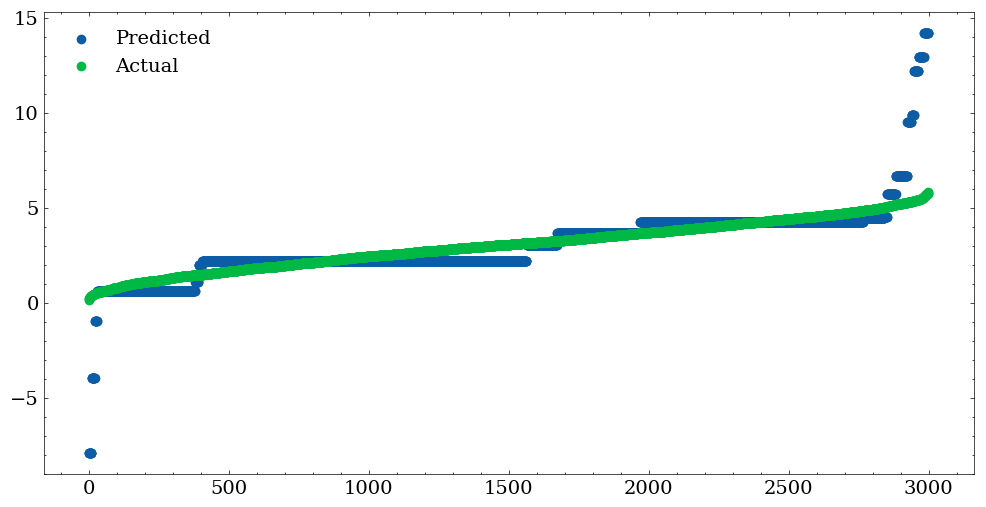

In [11]:
with pretty.Classic():
    fig, ax = plt.subplots()
    ax.scatter(range(len(preds)), sorted(preds), label = 'Predicted')
    ax.scatter(range(len(true_test)), sorted(true_test), label = 'Actual')
    
    ax.set_xlabel('')
    ax.legend()

In [1]:
#%load_ext autoreload
#%autoreload 2

import ctree
import numpy as np

np.random.seed(1)
homog = ctree.Dataset(n = 500, m = 6, p_treated=0.5)
hetero = ctree.Dataset(n = 500, m = 6, p_treated=0.5, homogeneous=False)

X = hetero.df.drop('y', axis = 1).values
y = hetero.df['y'].values

In [2]:
from numba import njit
mse = njit(ctree.CART.MSE)

%timeit ctree.CART.Node(X,y, mse)

23.4 ms ± 510 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [3]:
%timeit ctree.CART.Node(X, y, ctree.CART.MSE, jit = False)

215 ms ± 1.29 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [5]:
# Jitted tree
p1 = ctree.Partition()
p1.fit(X,y)
%timeit p1.predict(X)

15 ms ± 520 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [6]:
# Unjitted tree
p2 = ctree.Partition(jit = False)
p2.fit(X,y)
%timeit p2.predict(X)

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
non-precise type pyobject
[1] During: typing of argument at /home/kristian/Documents/github/ctree/ctree/CART/jitted.py (10)

File "../ctree/CART/jitted.py", line 10:
def search_row_jitted(criterion, y, idx, row):
    <source elided>
    '''
    score = np.inf
    ^

This error may have been caused by the following argument(s):
- argument 0: cannot determine Numba type of <class 'function'>

This is not usually a problem with Numba itself but instead often caused by
the use of unsupported features or an issue in resolving types.

To see Python/NumPy features supported by the latest release of Numba visit:
http://numba.pydata.org/numba-doc/latest/reference/pysupported.html
and
http://numba.pydata.org/numba-doc/latest/reference/numpysupported.html

For more information about typing errors and how to debug them visit:
http://numba.pydata.org/numba-doc/latest/user/troubleshoot.html#my-code-doesn-t-compile

If you think your code should work with Numba, please report the error message
and traceback, along with a minimal reproducer at:
https://github.com/numba/numba/issues/new


/home/kristian/miniconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


<module 'matplotlib.pyplot' from '/home/kristian/miniconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

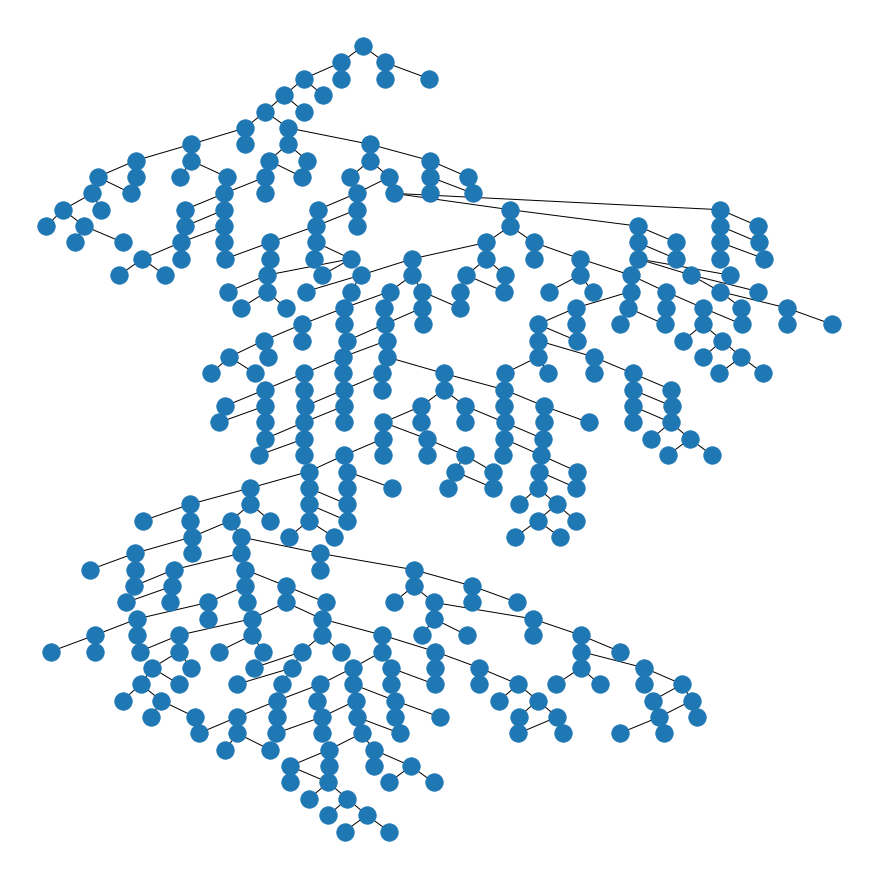

In [10]:
p = ctree.Partition()
p.fit(X, y)
ctree.plot_partition(p)

In [15]:
preds = p.predict(X)

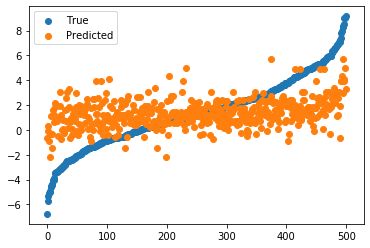

In [22]:
import matplotlib.pyplot as plt 
import pandas as pd 

df = pd.DataFrame({'p': preds, 'y': y}).sort_values('y').reset_index()
plt.scatter(df.index, df.y, label = 'True')
plt.scatter(df.index, df.p, label = 'Predicted')
plt.legend()

In [7]:
%timeit p1.fit(X,y)

377 ms ± 1.53 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
